In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [4]:
df = pdr.get_data_yahoo('BTC-USD', start='2020-01-01', end='2023-12-31')

df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095


## 가격 변화 계산

pct_change: 전날과 비교한 가격 변화

In [5]:
# Create a series of percentage returns
df['Returns'] = df['Adj Close'].pct_change()

df.head()

,Open,High,Low,Close,Adj Close,Volume,Returns
Date,,,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997,NaN
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465,-0.029819
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032,0.051452
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275,0.008955
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095,0.000089


## 연간 수익률의 변동성

금융 자산이나 포트폴리오의 수익률 변동성을 연간 기준으로 환산한 것

여기서 "변동성(Volatility)"은 자산의 가격 변동의 정도를 수치로 나타낸 것이며, 투자의 위험성을 측정하는 데 사용

특히, 수익률의 변동성은 투자 수익이 시간에 따라 얼마나 변동하는지를 나타내며, 이는 투자자가 투자 결정을 내리는 데 중요한 정보를 제공


$$ \sigma_{annual} = \sigma_{daily} \times \sqrt{252} $$

- sigma_{annual}: 연간 수익률의 변동성
- sigma_{daily}: 일일 수익률의 표준편차
- 252: 연간 평균 거래일 수

In [6]:
T = 252   # 연간 평균 거래일 수

# Calculate the annual volatility of returns
vol = df['Returns'].std() * np.sqrt(T)
print('the annual volatility of returns', vol)

the annual volatility of returns 0.5526024122574126


## 복합 연간 성장률(Compound Annual Growth Rate, CAGR)

특정 기간 동안의 평균 연간 성장률을 나타내는 지표 (산술평균이 아닌 기하평균)

$$ CAGR = \left( \frac{V_f}{V_i} \right)^{\frac{1}{n}} - 1 $$

- V_f: 최종 가치
- V_i: 초기 가치
- n: 기간(년)

In [7]:
# Calculate the compound annual growth rate (CAGR) which will give us our mean returns input (mu)
days = (df.index[-1] - df.index[0]).days
cagr = ((((df['Adj Close'][-1]) / df['Adj Close'][0])) ** (365.0 / days)) - 1

print(days)
print(cagr)

1459
0.5560119784442479


## 기하 브라운 운동(Geometric Brownian Motion, GBM) 모델

자산 가격의 미래 변동 시뮬레이션

기대 수익률에서 변동성의 절반을 뺀 값에 시간 간격을 곱한 후, 변동성과 시간 간격의 제곱근에 정규 분포에서의 랜덤 값을 곱한 값을 더하여, 주어진 시간 동안의 수익률을 계산

$$ \text{returns} = \left( \text{cagr} - 0.5 \times \text{vol}^2 \right) \times \text{dt} + \text{vol} \times \sqrt{\text{dt}} \times \text{rand_seq} $$

- cagr: 복합 연간 성장률
- vol: 연간 변동성
- dt: 시간 간격 (일반적으로 1년을 기준으로 한 일의 비율)
- rand_seq: 표준 정규 분포에서 추출된 랜덤 값

In [8]:
N = 100                    # 시뮬레이션 횟수
S0 = df['Adj Close'][-1]   # 최초 가격 (데이터의 마지막 가격)

# Generate random sequences for the Monte Carlo simulation
np.random.seed(0)
rand_seq = np.random.standard_normal((T + 1, N))

# Simulate the returns using GBM formula S(t) = S(0)*exp((mu-0.5*sigma**2)*t + sigma*sqrt(t)*Z)
dt = 1 / T

returns = (cagr - 0.5 * vol ** 2) * dt + vol * np.sqrt(dt) * rand_seq

price_sim = np.zeros_like(returns)
price_sim[0] = S0

print(rand_seq.shape)
print(returns.shape)

(253, 100)
(253, 100)


## 시뮬레이션

주어진 시간 간격 내에서 자산의 가격 경로를 시뮬레이션하기 위해 GBM 모델을 이용하는 과정

각 시간 단계에서, 자산 가격은 이전 가격에 그 시간 단계의 수익률을 적용하여 업데이트

$$ \text{price_sim}[t] = \text{price_sim}[t - 1] \times \exp(\text{returns}[t]) $$

- t: 시간 단계를 나타내며, 1부터 시작하여 T까지 증가
- price_sim[t]: 시간 t에서의 시뮬레이션된 가격
- exp(returns[t]): 시간 t에서의 수익률, 해당 시간 단계에서의 가격 변동 모델링

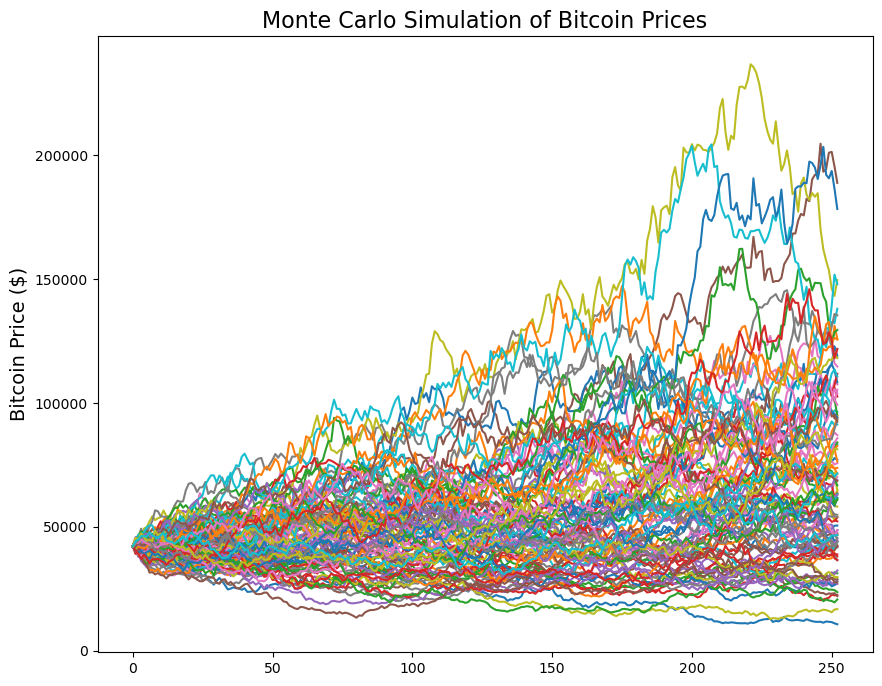

In [9]:
for t in range(1, T + 1):
    price_sim[t] = price_sim[t - 1] * np.exp(returns[t])

# Plot the simulated price paths
plt.figure(figsize=(10, 8))
plt.plot(price_sim)
plt.ylabel('Bitcoin Price ($)', fontsize=14)
plt.title('Monte Carlo Simulation of Bitcoin Prices', fontsize=16)
plt.show()

## 투자 시뮬레이션

- 10,000 달러 투자 시작

### 예시

- [구매] 비트코인 가격이 시뮬레이션된 평균 가격보다 2% 이상 낮다면, 전체 USD 잔액으로 비트코인 구매
- [판매] 비트코인 가격이 시뮬레이션된 평균 가격보다 2% 이상 높다면, 보유 중인 모든 비트코인 판매

In [10]:
# Initial conditions
initial_investment = 10000.0
buy_threshold = -0.02
sell_threshold = 0.02
num_simulations = 10

# Results storage
results = []

# Run strategy multiple times
for simulation in range(num_simulations):
    # Initial balance
    usd_balance = initial_investment
    btc_balance = 0.0

    # Run strategy
    for t in range(T):
        price = price_sim[t, simulation]
        simulated_price = np.mean(price_sim[t])
        if price < simulated_price * (1 + buy_threshold) and usd_balance > 0:
            btc_to_buy = usd_balance / price
            btc_balance += btc_to_buy
            usd_balance = 0.0
        elif price > simulated_price * (1 + sell_threshold) and btc_balance > 0:
            usd_to_sell = btc_balance * price
            usd_balance += usd_to_sell
            btc_balance = 0.0

    # Final portfolio value
    portfolio_value = usd_balance + btc_balance * price_sim[-1, simulation]

    # Calculate profit/loss
    profit_loss = portfolio_value - initial_investment
    results.append(profit_loss)

# Convert results to numpy array for easier analysis
results = np.array(results)

# Display results
print('Mean profit/loss:', np.mean(results))
print('Standard deviation of profit/loss:', np.std(results))
print('Minimum profit/loss:', np.min(results))
print('Maximum profit/loss:', np.max(results))

Mean profit/loss: 3593.882394091642
Standard deviation of profit/loss: 5112.002352204514
Minimum profit/loss: -4493.104369157202
Maximum profit/loss: 14331.601718529248
